# 79.1666667- Self implementation 
# 69.2916  - SkLearn Package

In [156]:
import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch.utils.data as Data
from sklearn import datasets
import random 
import os
from keras.layers import Dense, Convolution2D, UpSampling2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, Reshape
from keras.models import Sequential
from keras.utils import np_utils


In [157]:
TempData=pd.read_csv('../data/Cancer/dataR2.csv')
TempData.head()
TempData.columns

Index([u'Age', u'BMI', u'Glucose', u'Insulin', u'HOMA', u'Leptin',
       u'Adiponectin', u'Resistin', u'MCP.1', u'Classification'],
      dtype='object')

In [158]:
d=np.asarray(TempData.values)
np.random.shuffle(d)
print d[1]
head="Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification"
np.savetxt("cancerData.csv", d, delimiter=",",header=head)

[ 60.          31.23140988 131.          30.13         9.73600733
  37.843        8.40443     11.50005    396.021        2.        ]


In [159]:
data=pd.read_csv('./cancerData.csv')
#data.head(100)

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 115
Data columns (total 10 columns):
# Age             116 non-null float64
BMI               116 non-null float64
Glucose           116 non-null float64
Insulin           116 non-null float64
HOMA              116 non-null float64
Leptin            116 non-null float64
Adiponectin       116 non-null float64
Resistin          116 non-null float64
MCP.1             116 non-null float64
Classification    116 non-null float64
dtypes: float64(10)
memory usage: 10.0 KB


In [161]:
data['Classification'].unique()

array([1., 2.])

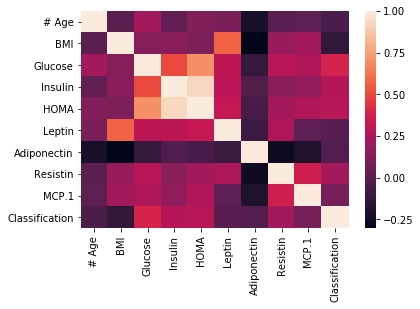

In [162]:
sns.heatmap(data.corr())

In [163]:
data.columns
    

Index([u'# Age', u'BMI', u'Glucose', u'Insulin', u'HOMA', u'Leptin',
       u'Adiponectin', u'Resistin', u'MCP.1', u'Classification'],
      dtype='object')

In [164]:
input_col=['# Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin',
       'Adiponectin', 'Resistin', 'MCP.1'] 
output_col=['Classification']
data=data.dropna()
data=data.reset_index(drop=True)
X=data[input_col]
y=data[output_col]

print X.shape,y.shape

(116, 9) (116, 1)


In [165]:
def divide_data(x_data, fkey, fval):
    x_right = pd.DataFrame([], columns=x_data.columns)
    x_left = pd.DataFrame([], columns=x_data.columns)
    
    
    for ix in xrange(x_data.shape[0]):
        # Retrieve the current value for the fkey column
        val = x_data[fkey].loc[ix]
        
        # Check where the row needs to go
        if val > fval:
            # pass the row to right
            x_right = x_right.append(x_data.loc[ix])
        else:
            # pass the row to left
            x_left = x_left.append(x_data.loc[ix])
    
    # return the divided datasets
    return x_left, x_right


def entropy(col):
    counts = np.unique(col, return_counts=True)
    N = float(col.shape[0])
    
    ent = 0.0
    for ix in range(counts[0].shape[0]):
        frac = counts[1][ix] / N
        ent += (-1.0 * frac * np.log2(frac))
    return ent

def information_gain(xdata, fkey, fval):
    left, right = divide_data(xdata, fkey, fval)
    P = left.shape[0] / float(xdata.shape[0])
    Q = right.shape[0] / float(xdata.shape[0])
    
    if left.shape[0] == 0 or right.shape[0] == 0:
        return -10000
    
    return entropy(xdata.Classification) - (P*entropy(left.Classification) + Q*entropy(right.Classification))

In [166]:
for ix in X.columns:
    #print type(ix)
    print " | ",ix," : ",information_gain(data,ix,data[ix].mean())

 |  # Age  :  0.010335095597152733
 |  BMI  :  0.00026402305607264864
 |  Glucose  :  0.12532498717969465
 |  Insulin  :  0.06376640147809498
 |  HOMA  :  0.06678700098773582
 |  Leptin  :  0.000624746421923561
 |  Adiponectin  :  0.005399029714207915
 |  Resistin  :  0.06577355892570513
 |  MCP.1  :  0.0001513799386176906


In [167]:
class DecisionTree:
    def __init__(self, depth=0, max_depth=5):
        self.left = None
        self.right = None
        self.fkey = None
        self.fval = None
        self.max_depth = max_depth
        self.depth = depth
        self.target = None
    
    def train(self, X_train):
        print self.depth, '-'*10
        # Get the best possible feature and division value
        features = ['# Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin',
       'Adiponectin', 'Resistin', 'MCP.1']
        gains = []
        for fx in features:
            gains.append(information_gain(X_train, fx, X_train[fx].mean()))
        
        # store the best feature (using min information gain)
        self.fkey = features[np.argmax(gains)]
        self.fval = X_train[self.fkey].mean()
        
        # divide the dataset
        data_left, data_right = divide_data(X_train, self.fkey, self.fval)
        data_left = data_left.reset_index(drop=True)
        data_right = data_right.reset_index(drop=True)
        
        # Check the shapes
        if data_left.shape[0] == 0 or data_right.shape[0] == 0:
            self.target = np.unique(X_train.Classification,return_counts=True)[0][(np.argmax(np.unique(X_train.Classification,return_counts=True)[1]))]
            return
        
        if self.depth >= self.max_depth:
            self.target = np.unique(X_train.Classification,return_counts=True)[0][(np.argmax(np.unique(X_train.Classification,return_counts=True)[1]))]
            return
        
        # branch to right
        self.right = DecisionTree(depth=self.depth+1, max_depth=self.max_depth)
        self.right.train(data_right)
        # branch to left
        self.left = DecisionTree(depth=self.depth+1, max_depth=self.max_depth)
        self.left.train(data_left)
        
        self.target = np.unique(X_train.Classification,return_counts=True)[0][(np.argmax(np.unique(X_train.Classification,return_counts=True)[1]))]

        
        return
    
    def predict(self, test):
        if test[self.fkey] > self.fval:
            # go right
            if self.right is None:
                return self.target
            return self.right.predict(test)
        else:
            # go left
            if self.left is None:
                return self.target
            return self.left.predict(test)

In [176]:
# random.shuffle(data)
split = int(0.8 * data.shape[0])
# s=int(0.2 * data.shape[0])
training_data = data[:split]
testing_data = data[split:]
# print split
# print training_data.shape
# print testing_data.shape

In [177]:
Accuracy=0
for i in range(100):
    dt = DecisionTree()
    dt.train(training_data)
    Acc=0
    num=0
    for ix in testing_data.index[:]:
        pred=dt.predict(testing_data.loc[ix])
        num+=1
        Ground=testing_data['Classification'].loc[ix]
        if pred==Ground:
            Acc+=1
        #print pred,Ground
       # print '-'*15
    
    print float(Acc)/num
    Accuracy+=float(Acc)/num

print Accuracy/100    

0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 --------

4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 --------

5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 --------

2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 --------

4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 --------

5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ------

5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ------

5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 --------

4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 --------

5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
0.791666666667
0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 --------

In [178]:
print Accuracy/100  

0.791666666667


In [175]:
# print dt.fkey, dt.fval
# print dt.right.fkey, dt.right.fval
# print dt.left.fkey, dt.left.fval

# print dt.right.right.fkey, dt.right.right.fval
# print dt.right.left.fkey, dt.right.left.fval


# print dt.left.right.fkey, dt.left.right.fval
# print dt.left.left.fkey, dt.left.left.fval


In [179]:
Acc=0
num=0
for ix in testing_data.index[:]:
    pred=dt.predict(testing_data.loc[ix])
    num+=1
    Ground=testing_data['Classification'].loc[ix]
    if pred==Ground:
        Acc+=1
    #print pred,Ground
   # print '-'*15
    
print float(Acc)/num

0.791666666667


In [180]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [181]:
acc=0
for i in range(100):
    DT = DecisionTreeClassifier()
    DT.fit(X[:split], y[:split])
    acc=acc+DT.score(X[split:],y[split:])
    
print acc/100;

0.6929166666666668
